In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from matplotlib.gridspec import GridSpec
import re
import nltk
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# !pip install tensorflow keras
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

nltk.download('stopwords')  
nltk.download('punkt')

from warnings import filterwarnings
filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
resumeDataSet = pd.read_csv('/content/UpdatedResumeDataSet.csv' ,encoding='utf-8')
resumeDataSet.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [3]:
print("Distinct categories of resume:")
print(resumeDataSet['Category'].unique())

Distinct categories of resume:
['Data Science' 'HR' 'Advocate' 'Arts' 'Web Designing'
 'Mechanical Engineer' 'Sales' 'Health and fitness' 'Civil Engineer'
 'Java Developer' 'Business Analyst' 'SAP Developer' 'Automation Testing'
 'Electrical Engineering' 'Operations Manager' 'Python Developer'
 'DevOps Engineer' 'Network Security Engineer' 'PMO' 'Database' 'Hadoop'
 'ETL Developer' 'DotNet Developer' 'Blockchain' 'Testing']


In [4]:
print("Number of records for each category:")
print(resumeDataSet['Category'].value_counts())

Number of records for each category:
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: Category, dtype: int64


<Axes: xlabel='count', ylabel='Category'>

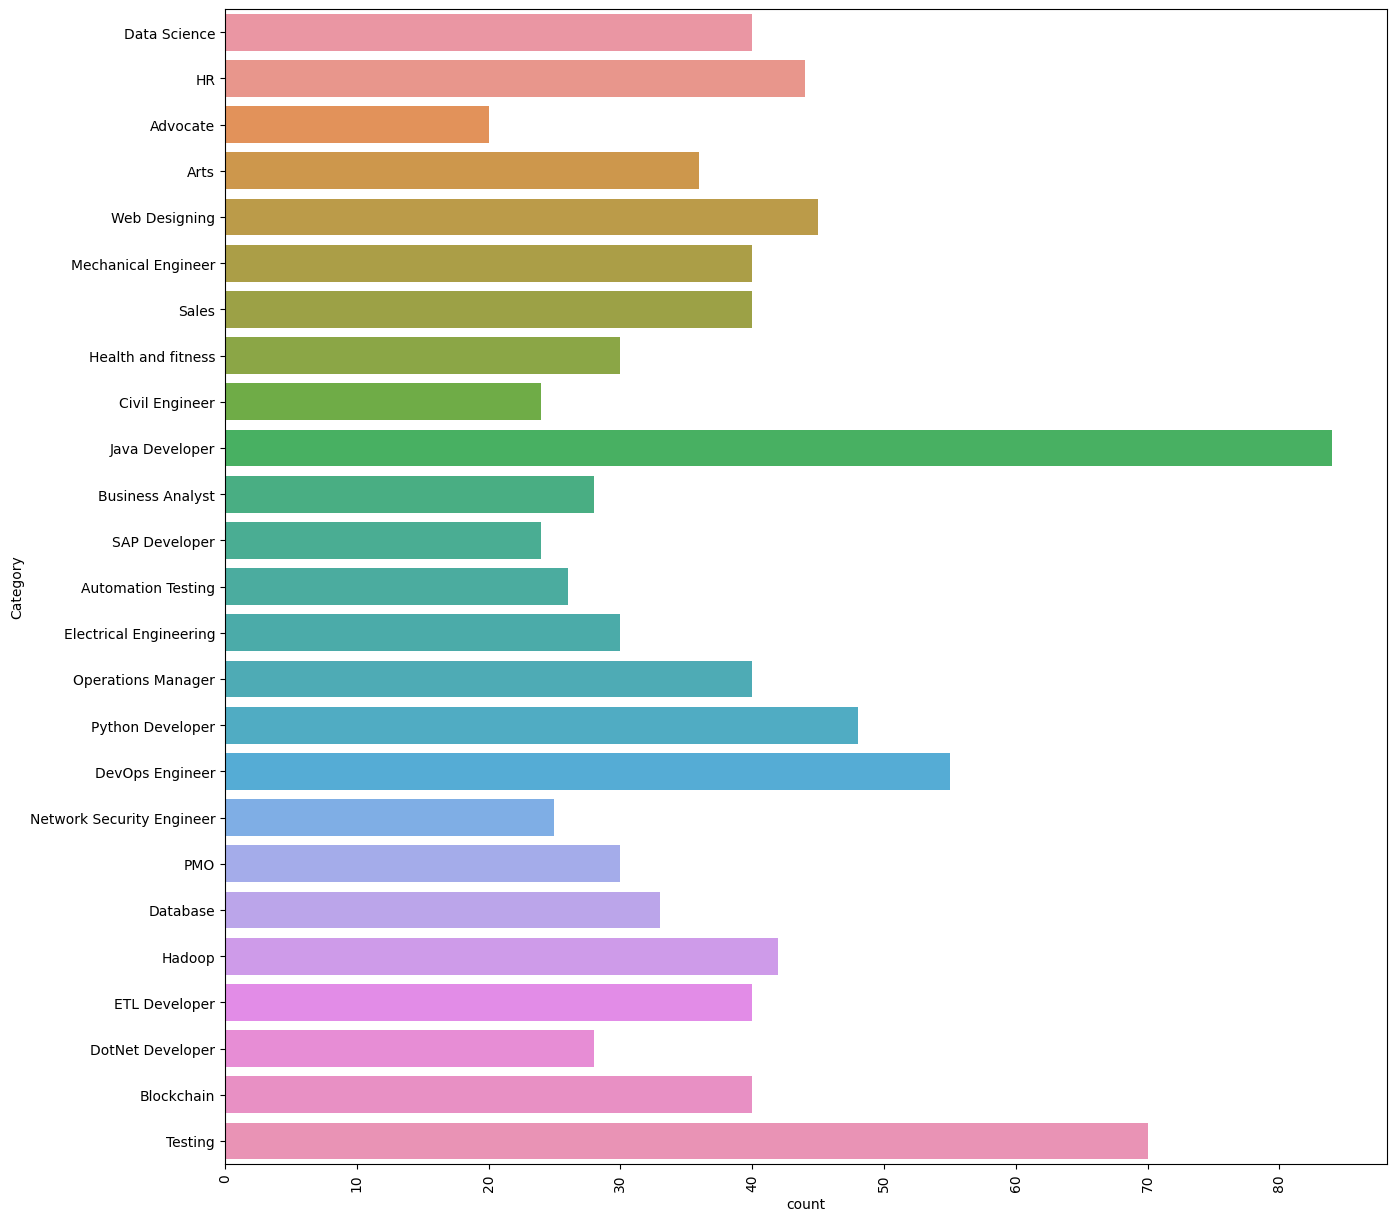

In [5]:
plt.figure(figsize=(15,15))
plt.xticks(rotation=90)
sns.countplot(y="Category", data=resumeDataSet)

In [ ]:
# targetCounts = resumeDataSet['Category'].value_counts()
# targetLabels  = resumeDataSet['Category'].unique()
# # Make square figures and axes
# plt.figure(1, figsize=(25,25))
# the_grid = GridSpec(2, 2)


# cmap = plt.get_cmap('coolwarm')
# colors = [cmap(i) for i in np.linspace(0, 1, 6)]
# plt.subplot(the_grid[0, 1], aspect=1, title='CATEGORY DISTRIBUTION')

# source_pie = plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', shadow=True, colors=colors)
# plt.show()

In [6]:
def cleanResume(resumeText):
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText) 
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    return resumeText
    
resumeDataSet['cleaned_resume'] = resumeDataSet.Resume.apply(lambda x: cleanResume(x))

In [7]:
oneSetOfStopWords = set(stopwords.words('english')+['``',"''"])
totalWords =[]
Sentences = resumeDataSet['Resume'].values
cleanedSentences = ""
for i in range(0,160):
    cleanedText = cleanResume(Sentences[i])
    cleanedSentences += cleanedText
    requiredWords = nltk.word_tokenize(cleanedText)
    for word in requiredWords:
        if word not in oneSetOfStopWords and word not in string.punctuation:
            totalWords.append(word)
    
wordfreqdist = nltk.FreqDist(totalWords)
mostcommon = wordfreqdist.most_common(50)
print(mostcommon)

# wc = WordCloud().generate(cleanedSentences)
# plt.figure(figsize=(15,15))
# plt.imshow(wc, interpolation='bilinear')
# plt.axis("off")
# plt.show()

[('Details', 484), ('Exprience', 446), ('months', 376), ('company', 330), ('description', 310), ('1', 290), ('year', 232), ('January', 216), ('Less', 204), ('Data', 200), ('data', 192), ('Skill', 166), ('Maharashtra', 166), ('6', 164), ('Python', 156), ('Science', 154), ('I', 146), ('Education', 142), ('College', 140), ('The', 126), ('project', 126), ('like', 126), ('Project', 124), ('Learning', 116), ('India', 114), ('Machine', 112), ('University', 112), ('Web', 106), ('using', 104), ('monthsCompany', 102), ('B', 98), ('C', 98), ('SQL', 96), ('time', 92), ('learning', 90), ('Mumbai', 90), ('Pune', 90), ('Arts', 90), ('application', 84), ('Engineering', 78), ('24', 76), ('various', 76), ('Software', 76), ('Responsibilities', 76), ('Nagpur', 76), ('development', 74), ('Management', 74), ('projects', 74), ('Technologies', 72), ('Used', 72)]


In [8]:
le = LabelEncoder()
for i in ['Category']:
    resumeDataSet[i] = le.fit_transform(resumeDataSet[i])

In [9]:
requiredText = resumeDataSet['cleaned_resume'].values
requiredTarget = resumeDataSet['Category'].values

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english',
    max_features=1500)
word_vectorizer.fit(requiredText)
WordFeatures = word_vectorizer.transform(requiredText)

print ("Feature completed .....")

X_train,X_test,y_train,y_test = train_test_split(WordFeatures,requiredTarget,random_state=42, test_size=0.2,
                                                 shuffle=True, stratify=requiredTarget)
print(X_train.shape)
print(X_test.shape)

Feature completed .....
(769, 1500)
(193, 1500)


In [10]:
clf = OneVsRestClassifier(KNeighborsClassifier())
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
print('Accuracy of KNeighbors Classifier on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of KNeighbors Classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))

print("\n Classification report for classifier %s:\n%s\n" % (clf, metrics.classification_report(y_test, prediction)))

Accuracy of KNeighbors Classifier on training set: 0.99
Accuracy of KNeighbors Classifier on test set: 0.99

 Classification report for classifier OneVsRestClassifier(estimator=KNeighborsClassifier()):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         8
           4       0.86      1.00      0.92         6
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         7
           8       1.00      0.91      0.95        11
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         8
          11       0.86      1.00      0.92         6
          12       1.00      1.00      1.00         9
          13       1.00      1.00      1.

**Tokenize features and labels**

In [11]:
vocab_size = 6000
embedding_dim = 16
max_length = 6000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

**Tokenizing features -**

In [12]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(requiredText)
word_index = tokenizer.word_index

In [13]:
X_sequences = tokenizer.texts_to_sequences(X_train)
X_padded = pad_sequences(X_sequences,maxlen=max_length,padding=padding_type, truncating=trunc_type)

AttributeError: ignored

In [ ]:
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, padding=padding_type, truncating=trunc_type)

**Tokenizing labels -**

In [ ]:
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(y)
word_index = tokenizer.word_index

In [ ]:
y_sequences = tokenizer.texts_to_sequences(y_train)
# y_padded = pad_sequences(y_sequences,maxlen=300,padding=padding_type, truncating=trunc_type)

In [ ]:
y_testing_sequences = tokenizer.texts_to_sequences(y_test)
# y_testing_padded = pad_sequences(y_testing_sequences,maxlen=300, padding=padding_type, truncating=trunc_type)

In [ ]:
y_sequences[:5]

**Building the model**

In [ ]:
embedding_dim = 64
# input vocab of size 6000, and output embedding dimension of size 64 

model = Sequential([
  Embedding(vocab_size, embedding_dim,),
  Bidirectional(LSTM(64)),
  Dense(64, activation='relu'),
  Dense(26, activation='softmax')# 26 lables are there....
])

model.summary()

In [ ]:
# loss = tf.keras.losses.sparse_categorical_crossentropy(from_logits=False)
# loss = tf.keras.losses.categorical_crossentropy(from_logits=True)

model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

y_padded = np.array(y_sequences)
y_testing_padded = np.array(y_testing_sequences)

In [ ]:
earlyStopping = EarlyStopping(monitor='val_loss',patience=2)

history = model.fit(X_padded,y_padded,epochs = 15, validation_data=(testing_padded,y_testing_padded ), callbacks=[earlyStopping])

In [ ]:
score = model.evaluate(testing_padded, y_testing_padded, verbose=1)

In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()